# 从 DFT 到 MD｜超详细「深度势能」材料计算上手指南（上）

<a href="https://bohrium.dp.tech/notebook/879b6a3a9d394448913ca1ce7de257ec" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>


In [1]:
# Copyright 2023 @ DP Technology
#
# 作者: Wenshuo Liang [liangws@dp.tech]
# 创建日期: 2023-04-13
# 演绎: Haohui Que [quehaohui@dp.tech]
# 最后一次修改时间: 2023-04-23 
#
# 共享协议: 本作品采用[知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议]进行许可。
# 你可以在该网站获得该协议的具体信息：https://creativecommons.org/licenses/by-nc-sa/4.0/

<span style="color:purple">**这是目前最完整地覆盖从第一性原理计算到分子动力学模拟的超详细「深度势能」材料计算上手指南，主要面向需要入门深度势能材料计算的零基础用户。**</span>

或者你仅需要 10 分钟快速了解 DeePMD-kit，可戳 👉 [DeePMD-kit｜快速开始](https://bohrium.dp.tech/notebook/759614d6c6314dee84a127f11dfc4723)

本教程可在 [Bohrium Notebook](https://bohrium-doc.dp.tech/docs/userguide/Notebook) 上直接运行。**想试试新的想法？不要犹豫，你可以快速将本教程保存至自己的 Bohrium 数据盘，直接进行交互式练习。不需要再困扰于如何从头开始安装所需软件。**

在 Bohrium Notebook 界面，你可以点击界面上方蓝色按钮 `开始连接`，选择 `abacus:3.2.1-deepmd` 镜像及任何一款节点配置，稍等片刻即可运行。

<div style="padding: 10px; background-color: #f5f5f5; color: black; margin-bottom: 15px; border-radius: 30px;">
    <p style='padding: 10px'>本教程可一键运行，<b>完整运行该教程需要约 20 小时</b> （16 核 32G 内存节点配置下）。如您希望快速运行，可以<b>跳过注释了 Time Warning 的单元，这将大幅缩短运行时间至 1 分钟。</b></p>
        <p style='padding-left: 10px; padding-right: 10px;'>请放心，这并不会影响你的学习体验。我们已为您运行并准备好了运行结果文件。</p>
</div>

如您遇到任何问题，请联系 [bohrium@dp.tech](mailto:bohrium@dp.tech) 。

<div style="width:auto; height:2px; background:linear-gradient(244deg,rgba(0,0,0,0) 0%,rgba(0,0,0,0.5) 50%,rgba(0,0,0,1) 100%)"></div>


## 背景

![LiCl](https://ars.els-cdn.com/content/image/1-s2.0-S1005030220309075-fx1_lrg.jpg)

在本教程中，我们将以 LiCl 熔体为例，详细介绍深度势能（Deep Potential）模型的训练和应用。深度势能模型是一种基于机器学习的方法，用于精确描述原子间相互作用的势能面。通过训练这种模型，我们可以高效地模拟材料的结构、动力学和热力学性质。具体包括以下示例：

* 章节 1: LAMMPS 经典分子动力学模拟
* 章节 2: ABACUS 第一性原理计算
* 章节 3: DeePMD-kit 深度势能模型训练
* 章节 4: DP-GEN 构建训练数据并生成深度势模型
* 章节 5: LAMMPS 深度势能分子动力学研究

根据内容间的衔接，章节 1\~3 在上篇中进行介绍，章节 4\~5 在下篇中进行介绍。

总的来说，通过结合经典分子动力学模拟（如 LAMMPS）、第一性原理计算（如 ABACUS）和深度势能模型构建（DeePMD-kit 和 DP-GEN），我们可以多角度地研究 LiCl 熔体的性质。这些方法和工具的组合为研究复杂材料系统提供了强大的支持，帮助我们更好地理解材料在不同条件下的性能。

### 开始之前

我们很热切地希望与你分享我们的知识，但是在现在：

**你不需要了解所有事（至少目前是）。** 你的目标是从头到尾完成本教程并获得结果。你不需要在第一次尝试时就了解所有内容。边学习边写下你的问题。使用丰富的 API 文档来了解你正在使用的所有功能。

**你不需要知道算法是如何工作的。** 了解各种计算模拟的优点和局限性以及如何配置材料计算参数非常重要。但是学习可以稍后进行。你需要在很长一段时间内慢慢建立这种计算模拟知识，并且你可以阅读大量教程来复习材料计算项目的步骤。今天，首先要熟悉这个平台。

了解以下基础概念可以帮助你更快速地理解本文：

* 分子动力学 (Molecular Dynamics, MD)，如果你尚未了解，推荐阅读：
    * [5 分钟快速了解分子动力学]()
* 密度泛函理论 (Density Fuctional Theory，DFT)，如果你尚未了解，推荐阅读：
    * [5 分钟快速了解密度泛函理论]()

## 章节 1：LAMMPS 经典分子动力学模拟

对于 LiCl 熔体，可以使用 LAMMPS（Large-scale Atomic/Molecular Massively Parallel Simulator）软件进行经典分子动力学模拟。[LAMMPS](https://www.lammps.org) 是一个高度灵活且可扩展的分子动力学模拟软件，支持多种原子间势和模拟条件。在这个示例中，我们使用经典 BMH 势函数模拟 LiCl 熔体的结构和动力学性质。

本章节采用 DeePMD-kit(2.2.1) 软件包中预置的 LAMMPS 程序完成。

### 本章节目标

在学习本章节后，你将能够：

- 了解 LAMMPS 的输入和输出文件；
- 能够为 LiCl 熔体撰写 LAMMPS MD 模拟输入文件；
- 计算 LiCl 熔体的微观结构和扩散性质。

### 1.1 下载教程资源

在本章节中，我们以 LiCl 熔体分子为例，进行 LAMMPS 经典分子动力学模拟。我们已经在 *LiCl_DP_Tutorial_Example/chapter1* 中准备了需要的文件，使用以下命令下载：

In [3]:
# 下载教程文件
! if ! [ -e LiCl_DP_Tutorial_Example]; then wget https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/LiCl_DP_Tutorial/LiCl_DP_Tutorial_Example.zip && unzip LiCl_DP_Tutorial_Example.zip; fi;

/bin/bash: line 1: [: missing `]'
--2023-04-25 11:55:56--  https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/LiCl_DP_Tutorial/LiCl_DP_Tutorial_Example.zip
Resolving bohrium-example.oss-cn-zhangjiakou.aliyuncs.com (bohrium-example.oss-cn-zhangjiakou.aliyuncs.com)... 47.92.18.28
Connecting to bohrium-example.oss-cn-zhangjiakou.aliyuncs.com (bohrium-example.oss-cn-zhangjiakou.aliyuncs.com)|47.92.18.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12588393 (12M) [application/zip]
Saving to: ‘LiCl_DP_Tutorial_Example.zip’

LiCl_DP_Tutorial_Ex 100%[===================>]  12.00M  47.0MB/s    in 0.3s    

2023-04-25 11:55:56 (47.0 MB/s) - ‘LiCl_DP_Tutorial_Example.zip’ saved [12588393/12588393]

Archive:  LiCl_DP_Tutorial_Example.zip
   creating: LiCl_DP_Tutorial_Example/
   creating: LiCl_DP_Tutorial_Example/chapter1/
   creating: LiCl_DP_Tutorial_Example/chapter5/
   creating: LiCl_DP_Tutorial_Example/chapter2/
   creating: LiCl_DP_Tutorial_Example/

在 *LiCl_DP_Tutorial_Example/chapter1* 文件夹包含以下文件：

- `licl.in`: LAMMPS 输入文件，用于控制 LAMMPS MD 模拟的细节；
- `licl.data`: 用于存放 MD 模拟的初始构型；

### 1.2 LAMMPS 输入文件

输入文件的作用是告诉 LAMMPS 软件其应该如何计算。通常将文件命名为“input.in”，其中“input”可以是任何描述性名称，以便于识别该模拟的类型或参数。

下面是一个 LiCl 熔体 LAMMPS 分子动力学模拟输入文件的示例：

```
# this input script is for simulating a 3d LiCl melt at 900K using LAMMPS.

# initialize simulation settings
units           metal
boundary        p p p
atom_style      charge

# define the simulation cell
read_data       licl.data
group           Li  type 1
group           Cl  type 2
set             type 1 charge 1
set             type 2 charge -1

# set force field
pair_style      born/coul/long 7
pair_coeff      1 1 0.4225000 0.3425 1.632 0.045625 0.01875
pair_coeff      1 2 0.2904688 0.3425 2.401 1.250000 1.50000
pair_coeff      2 2 0.1584375 0.3425 3.170 69.37500 139.375
kspace_style    ewald 1.0e-6 	

# nvt simulation  
velocity        all create 900 23456789
fix             1 all nvt temp 900 900 0.5
timestep        0.001

# rdf calculation 
compute         rdf all rdf 100 1 1 1 2 2 2
fix             2 all ave/time 100 1 100 c_rdf[*] file licl.rdf mode vector

# msd calculation
compute         msd1 Li msd
compute         msd2 Cl msd
fix             3 all ave/time 100 1 100 c_msd1[4] c_msd2[4] file licl.msd

# output
thermo_style    custom step temp pe ke etotal press lx ly lz vol
thermo          1000
dump            1 all custom 1000 licl.dump id type x y z 

log             ./LiCl_DP_Tutorial_Example/Chapter1/Outputs/log.lammps
run             500000
```

让我们来看一下各输入文件中各参数的含义：

- `units metal`：用于设置模拟中使用的单位系统。对于 metal，时间的单位是皮秒（ps），长度的单位是埃（Å），质量的单位是原子质量单位（amu），能量的单位是电子伏特（eV），温度的单位是开尔文（K），压力的单位是巴（bar），速度的单位是埃/皮秒（Å/ps）。

- `boundary p p p`：用于设置模拟的边界条件。在本教程情况下，我们在 x, y, z 三个方向上均使用周期性（periodic）边界条件。p 表示周期性，f (fixed) 表示固定边界条件。

- `atom_style charge`：用于设置原子类型和属性。在这个示例中，我们使用带电原子模型，因此使用了 charge 类型。

- `read_data licl.data`：用于读取数据文件 licl.data，同时也是该案例中 MD 模拟所使用的初始构型。

- `group Li type 1` 和 `group Cl type 2`：用于根据原子类型创建两个组，分别包含元素类型为 1（Li）和元素类型为 2（Cl）的所有原子。

- `set type 1 charge 1` 和 `set type 2 charge -1`：用于设置原子类型 1 和 2 的电荷。在这个示例中，元素类型 1（Li）的原子被设置为带有 +1 电荷，元素类型 2（Cl）的原子被设置为带有 -1 电荷。

- `pair_style born/coul/long 7`：该命令用于设置原子之间的相互作用势函数。在这个示例中，我们使用 Born−Mayer−Huggins 势函数：

$$ U_{i j}(r)=\frac{q_i q_j}{r}+A_{i j} b \exp \left(\frac{\sigma_{i j}-r}{\rho}\right)-\frac{C_{i j}}{r^6}-\frac{D_{i j}}{r^8} $$

其中第一项描述了离子之间的静电相互作用，$q_i$ 是离子电荷（$q_{Li}$= +1，$q_{Cl}$=-1）；第二项描述由于电子云的重叠引起的短程斥力，$A_{i j}$ 是 Pauling 因子（$A_{Li Li}$=2.00，$A_{Li Cl}$=1.375，$A_{Cl Cl}$=0.75），b 是一个常数（$b=0.338 \times 10^{-19} \mathrm{~J}$），$σ_{i j}$ 是晶体离子半径，而 ρ 是硬度参数 ($ρ_{LiCl}$ = 0.3425 Å)；最后两项对应于偶极-偶极和偶极-四极子色散相互作用，其中 $C_{i j}$和$D_{i j}$ 是色散参数。7 是截断距离（cutoff distance），单位为 Å，超过这个距离的原子间作用将被忽略。

|    |$A_{i j}b$(eV)|$σ_{i j}$(Å)|$C_{i j}$(eV)|$D_{i j}$(eV)|
|----|--------------|------------|-------------|-------------| 
| ++ | 0.4225000    | 1.632      |0.045625     |0.01875      |
| +- | 0.2904688    | 2.401      |1.250000     |1.50000      |
| -- | 0.1584375    | 3.170      |69.37500     |139.375      |

- `pair_coeff`：这些命令用于为相互作用势函数设置参数。每个 pair_coeff 命令将相互作用势函数中的原子类型之间的参数设置为指定值。在这个示例中，我们设置了 1 1、1 2 和 2 2 之间的参数。

- `kspace_style ewald 1.0e-6`：该命令用于设置 Ewald 方法计算长程库仑相互作用。在这个示例中，我们使用了Ewald方法，使用了 1.0e-6 的精度。

- `velocity all create 900 23456789`：该命令用于为模拟系统中的所有原子设置随机速度。

- `fix 1 all nvt temp 900 900 0.5`：该命令用于对模拟系统进行 NVT （等温-等体积）模拟。在这个示例中，我们将模拟系统保持在 900K 的恒定温度下，并使用Nose-Hoover 算法进行温度控制。0.5 是温度阻尼系数。

- `timestep 0.001`：该命令用于设置模拟的时间步长。在这个示例中，时间步长为 0.001 皮秒。

- `compute rdf all rdf 100 1 1 1 2 2 2`：该命令用于计算模拟系统中两种原子之间的径向分布函数（RDF）。100表示分100个统计区间，1 1 表示 Li-Li RDF，1 2表示Li-Cl RDF，2 2 表示 Cl-Cl RDF。

- `fix 2 all ave/time 100 1 100 c_rdf[*] file licl.rdf mode vector`：该命令用于对计算的RDF数据进行时间平均，并将结果输出到文件中。使用 fix 2 对RDF 数据进行时间平均，100 1 100 分别为 Nevery (每100步计算1次 rdf)，Nrepeat(平均最近1次的计算的 rdf，用于输出)和 Nfrequency(每 100 步输出一次 rdf)， 在这个案例中会每 100 步会输出一次 rdf。使用 c_rdf[*] 表示平均所有 RDF 分量，使用 file licl.rdf 表示将结果输出到名为 licl.rdf 的文件中，使用 mode vector 表示输出向量格式的数据。

- `compute msd1 Li msd` 和 `compute msd2 Cl msd`：这些命令用于计算两种原子在模拟过程中的平均平方位移（MSD）。在这个示例中，我们使用 compute msd1 计算 Li 原子的 MSD，使用compute msd2 计算 Cl 原子的 MSD。

- `fix 3 all ave/time 100 1 100 c_msd1[4] c_msd2[4] file licl.msd`：该命令用于对计算的 MSD 数据进行时间平均，并将结果输出到文件中。使用 fix 3 对 MSD 数据进行时间平均，使用 c_msd1[4] 和 c_msd2[4] 表示平均两种原子的MSD, 使用 file licl.msd 表示将结果输出到名为licl.msd的文件中。

- `thermo_style custom step temp pe ke etotal press lx ly lz vol`：该命令用于设置 LAMMPS 在模拟过程中输出的热力学信息。在这个示例中，我们使用`thermo_style custom` 表示使用自定义的输出格式，使用 `step temp pe ke etotal press lx ly lz vol` 表示要输出的信息，包括模拟步数、温度、势能、动能、总能量、压强以及模拟盒子的尺寸和体积。

- `thermo 1000`：该命令用于设置输出热力学信息的频率。在这个示例中，我们将每 1000 步输出一次热力学信息。

- `dump 1 all custom 1000 licl.dump id type x y z`：该命令用于在模拟过程中输出原子的坐标信息。在这个示例中，使用 `dump 1 all` 表示输出模拟系统中的所有原子，使用 `custom` 表示使用自定义的输出格式，使用 `1000` 表示输出频率，使用 `licl.dump` 表示输出文件的名称，使用 `id type x y z` 表示输出的原子信息，包括原子的 ID、类型以及在 x、y、z 方向上的坐标。

- `run 500000` 命令用于运行 LAMMPS 模拟，进行一定步数的时间演化。在这个示例中，该命令将模拟系统进行 500000 步时间演化。在每个时间步长中，LAMMPS 会根据当前的原子位置、速度和势能计算新的位置、速度和势能。通过这个过程，我们可以观察模拟系统的时间演化行为，比如温度、压力和分子运动轨迹等。需要注意的是，run 命令需要根据实际情况进行设置，以保证模拟过程的充分和准确。

你可以通过以下命令查看你刚才下载的 LAMMPS 案例的输入文件，与上述示例比较一下，有什么发现？

In [4]:
! cd ./LiCl_DP_Tutorial_Example/chapter1/ && cat licl.in

# this input script is for simulating a 3d LiCl melt at 900K using LAMMPS.

# initialize simulation settings
units           metal
boundary        p p p
atom_style      charge

# define the simulation cell
read_data	licl.data
group		Li  type 1
group		Cl  type 2
set 		type 1 charge 1
set 		type 2 charge -1

# set force field
pair_style      born/coul/long 7
pair_coeff	1 1 0.4225000 0.3425 1.632 0.045625 0.01875
pair_coeff	1 2 0.2904688 0.3425 2.401 1.250000 1.50000
pair_coeff	2 2 0.1584375 0.3425 3.170 69.37500 139.375
kspace_style	ewald 1.0e-6 	

# nvt  
velocity        all create 900 23456789
fix             1 all nvt temp 900 900 0.5
timestep        0.001

# rdf calculation 
compute 	 rdf all rdf 100 1 1 1 2 2 2
fix 		 2 all ave/time 100 1 100 c_rdf[*] file licl.rdf mode vector

# msd calculation
compute          msd1 Li msd
compute          msd2 Cl msd
fix              3 all ave/time 100 1 100 c_msd1[4] c_msd2[4] file licl.msd

# output
thermo_style    custom step temp pe ke etotal 

为了缩短运行所需的时间，我们适当降低了运行步数。你有新的想法吗？不要犹豫，快速试试你的新想法。

如果你没有偷懒的话，你已经仔细阅读了 2～3 遍 LAMMPS 输入文件，相信你已经对输入文件有了初步的了解。

还有许多疑惑？不用担心，这是正常的。你需要在接下来的时间里慢慢建立知识。[LAMMPS Commands 官方文档](https://docs.lammps.org/Commands.html) 提供了全面、详细的解释，在需要的时候不要忘了它。

### 1.3 LAMMPS 初始构型文件

下面是一个 LiCl 熔体 LAMMPS MD 模拟初始构型的示例：

```
# LAMMPS data file 
108 atoms
2 atom types
0.0 13.4422702789 xlo xhi
0.0 13.4422702789 ylo yhi
0.0 13.4422702789 zlo zhi

Masses

1 6.941  # Li
2 35.453  # Cl

Atoms  # charge

1 1 0.0 9.10297966 1.4528499842 12.3941898346  
2 1 0.0 11.53647995 2.3037500381 1.6365799904
3 1 0.0 1.3658800125 9.3088798523 4.9590802193
...
106 2 0.0 5.8468399048 2.629529953 3.9059700966
107 2 0.0 7.0047798157 5.3034000397 10.0816297531
108 2 0.0 4.4860801697 11.4718704224 13.3586997986
```

该文件描述模拟系统（LiCl）的基本信息和初始状态。

首先是模拟系统的基本信息：模拟系统中有 108 个原子，两种类型的原子（Li 和 Cl），模拟系统在 x、y、z 三个方向上的盒子大小分别是 0.0 到 13.4422702789，两种类型的原子的质量分别是 6.941 和 35.453。

后面一部分是原子的位置和电荷信息：每行依次表示原子的 ID、类型、电荷以及在 x、y、z 三个方向上的坐标。注意，此处电荷都是 0.0，我们可以在 *licl.in* 中重新规定电荷。

同样地，你可以通过以下命令查看你刚才下载的 LAMMPS 案例的构型数据文件。<span style="color:purple; font-weight:bold">自己动手试一下。</span>

```bash
cat ./LiCl_DP_Tutorial_Example/chapter1/licl.data
```

### 1.4 运行 LAMMPS 经典分子动力学模拟

经典分子动力学（Classical Molecular Dynamics，CMD）使用牛顿力学描述原子或分子间的相互作用。

在了解 licl.in 和 licl.data 文件后，我们可以执行以下命令以启动 LiCl 熔体的 LAMMPS 分子动力学模拟：

In [5]:
# 以下命令判断该环境中是否存在所需模块，如果没有，则使用 pip 快速安装。
! if ! pip show deepmd-kit > /dev/null; then pip install deepmd-kit[gpu,cu11,lmp]; fi;

In [6]:
# ############### Time Warning: 3 mins 35 secs ################### 
! cd ./LiCl_DP_Tutorial_Example/chapter1/ && lmp -i licl.in

LAMMPS (23 Jun 2022 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from /opt/deepmd-kit-2.2.1/lib/deepmd_lmp
Loaded 0 plugins from 
Reading data file ...
  orthogonal box = (0 0 0) to (13.44227 13.44227 13.44227)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  108 atoms
  read_data CPU = 0.002 seconds
54 atoms in group Li
54 atoms in group Cl
Setting atom values ...
  54 settings made for charge
Setting atom values ...
  54 settings made for charge
Ewald initialization ...
  using 12-bit tables for long-range coulomb (src/kspace.cpp:342)
  G vector (1/distance) = 0.4944418
  estimated absolute RMS force accuracy = 1.4603535e-05
  estimated relative force accuracy = 1.0141594e-06
  KSpace vectors: actual max1d max3d = 1054 8 2456
                  kxmax kymax kzmax  = 8 8 8
Generated 0 of 1 mixed pair_coeff terms from geometric mixing rule
Neighbor list info ...
  update every 

### 1.5 LAMMPS 分子动力学模拟结果与分析

运行完成后，我们可以看到在当前文件夹下生成了以下几个文件：

- log.lammps：日志文件，记录了模拟过程中的各种输出信息，包括初始系统状态、MD过程中的能量、温度、压力等物理量，以及各种计算的结果。
- licl.dump：轨迹文件，记录了模拟系统在每个时间步长中所有原子的位置、速度等信息。
- licl.rdf：径向分布函数（RDF）文件，记录了每 Nfrequency 步数输出的 RDF。
- licl.msd：均方位移（MSD）文件，记录了模拟系统中离子的均方位移随时间的变化。


对于 licl.dump 文件，我们可以使用 OVITO 等软件对完整轨迹进行可视化。在这里，我们使用 ASE 仅查看第一帧的图像。了解 ASE 的使用，请阅读[《快速开始 ASE》](https://bohrium.dp.tech/notebook/4918f71cdc61483389e060abfb04d324)

In [7]:
# 以下命令判断该环境中是否存在所需模块，如果没有，则使用 pip 快速安装。
! if ! pip show ase > /dev/null; then pip install --upgrade --user ase; fi;
! if ! pip show nglview > /dev/null; then pip install --upgrade --user nglview; fi;

In [14]:
from ase.io import lammpsrun
from ase.visualize import view

traj = lammpsrun.read_lammps_dump('./LiCl_DP_Tutorial_Example/chapter1/licl.dump')
print(traj)
view(traj, viewer='x3d')  # 该可视化需要运行后查看

Atoms(symbols='H54He54', pbc=True, cell=[13.4422702789, 13.4422702789, 13.4422702789])


对于 licl.rdf 文件，我们可以利用如下 Python 脚本进行进一步处理和绘图：

In [15]:
# 以下命令判断该环境中是否存在所需模块，如果没有，则使用 pip 快速安装。
! if ! pip show matplotlib > /dev/null; then pip install matplotlib; fi;

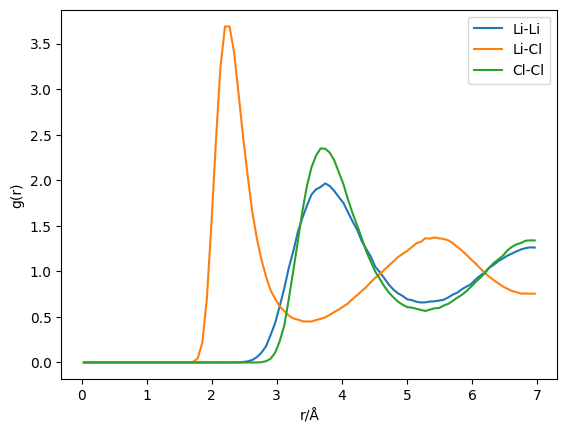

In [16]:
import numpy as np
import matplotlib.pyplot as plt

nbins = 100 # define the number of bins in the RDF

with open("./LiCl_DP_Tutorial_Example/chapter1/licl.rdf", "r") as f: # read the licl.rdf file
    lines = f.readlines()
    lines = lines[3:]

    data = np.zeros((nbins, 7))  
    count = 0  

    for line in lines:  
        nums = line.split()      
        if len(nums) == 8:  
            for i in range(1, 8):  
                data[int(nums[0])-1, i-1] += float(nums[i])  # accumulatie data for each bin  
        if len(nums) == 2:  
            count += 1         # count the number of accumulations for each bin
       
ave_rdf = data / count  # calculate the averaged RDF data
np.savetxt('./LiCl_DP_Tutorial_Example/chapter1/ave_rdf.txt', ave_rdf)

labels = ['Li-Li', 'Li-Cl', 'Cl-Cl']
for i, label in zip(range(1, 7, 2), labels):
    plt.plot(ave_rdf[:, 0], ave_rdf[:, i], label=label)
plt.xlabel('r/Å')
plt.ylabel('g(r)')
plt.legend()
plt.savefig('./LiCl_DP_Tutorial_Example/chapter1/rdf.png', dpi=300)
plt.show()


对于 licl.msd 文件，我们可以利用如下 Python 脚本进行进一步处理和绘图：

Diffusion Coefficients of Li+: 7.543639618987786e-09 m^2/s
Diffusion Coefficients of Cl-: 3.560272619733541e-09 m^2/s


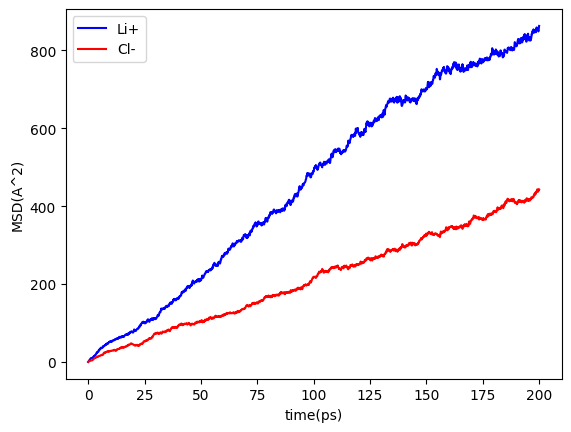

In [17]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('./LiCl_DP_Tutorial_Example/chapter1/licl.msd', skiprows=2)

time = data[:, 0]
msd1 = data[:, 1]
msd2 = data[:, 2]

plt.plot(time/1000, msd1, 'b-', label='Li+') # 1fs= 1/1000ps
plt.plot(time/1000, msd2, 'r-', label='Cl-')
plt.xlabel('time(ps)') 
plt.ylabel('MSD(A^2)')

slope1, residuals = np.polyfit(time, msd1, 1)
slope2, residuals = np.polyfit(time, msd2, 1)

Diff1 = slope1/6 * 1e-5  # D=1/6*slope; 1 A^2/fs = 1e-5 m^2/s
Diff2 = slope2/6 * 1e-5

print(f"Diffusion Coefficients of Li+: {Diff1} m^2/s")
print(f"Diffusion Coefficients of Cl-: {Diff2} m^2/s")

plt.legend()
plt.show()

以及从均方位移导出的扩散系数的数值：
```
Diffusion Coefficients of Li+: 6.226084916654326e-09 m^2/s
Diffusion Coefficients of Cl-: 3.5874140996046757e-09 m^2/s
```

注意：扩散系数的值可能和[文献](https://doi.org/10.1021/jp5050332)报道存在差异。我们可以考虑以下几个方面，以获得更准确的值：

- 首先在 NPT 系综进行模拟，将压力固定在 0 GPa，获得平衡体积。然后在平衡体积下进行 NVT 模拟。
- 使用更大的模拟盒子。
- 设置更长的模拟时间。

## 章节 2：ABACUS 第一性原理计算

对于 LiCl 熔体，我们还可以使用 ABACUS (Atomic-orbital Based Ab-initio Computation at UStc) 软件进行第一性原理计算。ABACUS 是一个基于密度泛函理论（DFT）的材料模拟软件，可以准确地计算原子间相互作用。通过使用 ABACUS，我们可以从电子结构层面研究 LiCl 熔体的性质。

### 本章节目标

在学习本章节后，你能够：

- 熟悉 ABACUS 软件的输入和输出文件；
- 为 LiCl 熔体编写 ABACUS SCF 计算输入文件并进行计算；
- 为 LiCl 熔体编写 ABACUS MD 计算输入文件并进行计算；

### 2.1 下载教程资源

在本章节中，我们以 LiCl 熔体分子为例,进行 ABACUS 第一性原理计算。我们已经在 *LiCl_DP_Tutorial_Example/chapter2* 中准备了需要的文件，使用以下命令下载：

本教程采用 ABACUS v3.2.0 完成。

In [ ]:
! if ! [ -e LiCl_DP_Tutorial_Example]; then wget https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/LiCl_DP_Tutorial/LiCl_DP_Tutorial_Example.zip && unzip LiCl_DP_Tutorial_Example.zip; fi;

在 *LiCl_DP_Tutorial_Example/chapter2* 文件夹中存在如下 5 种文件：

- `INPUT`：包含了计算过程中所需的各种参数，定义和控制计算任务；
- `STRU`：结构文件，包含了原子种类、原子位置、晶格常数以及晶格向量等信息；
- `KPT`：包含了布里渊区积分所需的k点信息；
- `*.upf`：包含了原子的赝势信息；
- `*.orb`：包含了原子轨道的数值表示；

### 2.2 ABACUS 自洽计算

首先，我们将使用 ABACUS 软件为 LiCl 熔体执行自洽计算。

自洽，是自洽场计算(SCF, self-consistent field calculation)的简称，它是密度泛函理论（DFT）算法的基础，也是 DFT 被称为第一性原理方法的原因。

从自洽场计算中我们可以得到一个体系的**基态结构**和**基态能量**。

基态结构使得我们可以得到体系的结构参数，例如晶胞参数，化学键键长键角等，而基态能量使得我们可以进一步得到原子受力和晶体材料的应力-应变性质等。

因此自洽场计算是开始做 DFT 计算的基础。

#### 2.2.1 ABACUS 自洽计算输入文件

你刚才下载了我们为本案例准备的 ABACUS 输入文件，让我们来通过以下命令查看。

1. *INPUT* 文件。INPUT 文件包含了与 LiCl 熔体 SCF 计算的相关参数：

In [18]:
! cd ./LiCl_DP_Tutorial_Example/chapter2/abacus_scf && cat INPUT

INPUT_PARAMETERS

#Parameters (1.General)
ntype                   2
symmetry                0
vdw_method              d3_bj

#Parameters (2.Iteration)
ecutwfc                 100
scf_thr                 1e-7
scf_nmax                120

#Parameters (3.Basis)
basis_type              lcao

#Parameters (4.Smearing)
smearing_method         gauss
smearing_sigma          0.002

#Parameters (5.Mixing)
mixing_type             pulay
mixing_beta             0.4

#Parameters (6.sfc)
calculation             scf
cal_force               1
cal_stress              1

对 INPUT 中各参数的介绍如下：

```
INPUT_PARAMETERS

#Parameters (1.General)
ntype                   2           # 原子种类的数量，这里设置为 2
symmetry                0           # 是否使用晶体对称性，0 表示不使用
vdw_method              d3_bj       # 范德华力的计算方法，这里选择 D3 方法，使用 Becke-Johnson 阻尼函数（d3_bj）

#Parameters (2.Iteration)
ecutwfc                 100         # 平面波基组截断能，这里设为 100 Ry
scf_thr                 1e-7        # 自洽场收敛阈值，设为 1.0e-7
scf_nmax                120         # 自洽场迭代的最大步数，设为 120

#Parameters (3.Basis)
basis_type              lcao        # 基组类型，这里选择线性组合原子轨道（LCAO）                     

#Parameters (4.Smearing)
smearing_method         gauss       # 展宽方法，这里选择高斯展宽（gauss）
smearing_sigma          0.002       # 展宽参数，这里设为 0.002 Ry

#Parameters (5.Mixing)
mixing_type             pulay       # 电荷密度混合方法，这里选择 Pulay 混合
mixing_beta             0.4         # 混合参数，设为 0.4

#Parameters (6.sfc)
calculation             scf                
cal_force               1           # 是否计算原子受力，设为 1 表示计算
cal_stress              1           # 是否计算应力，设为 1 表示计算
```

2. *STRU* 文件。STRU 文件包含了 LiCl 熔体的原子种类、原子位置、晶格常数以及晶格向量等信息。考虑到 DFT 计算成本相对较高，这里设计了一个较小的计算体系（64原子）：

In [19]:
! cd ./LiCl_DP_Tutorial_Example/chapter2/abacus_scf && cat STRU

ATOMIC_SPECIES
Li 6.941 Li_ONCV_PBE-1.2.upf
Cl 35.453 Cl_ONCV_PBE-1.2.upf

NUMERICAL_ORBITAL
Li_gga_8au_100Ry_4s1p.orb
Cl_gga_8au_100Ry_2s2p1d.orb

LATTICE_CONSTANT
1.8897261246257702

LATTICE_VECTORS
11.858 0.0 0.0 
0.0 11.858 0.0 
0.0 0.0 11.858 

ATOMIC_POSITIONS
Cartesian    # Cartesian(Unit is LATTICE_CONSTANT)
Li
0.0
32
3.01682  1.77597  4.37873  1  1  1
3.47660  5.23243  2.05957  1  1  1
0.90851  3.90744  4.56133  1  1  1
1.45547  -0.05347  0.89671  1  1  1
9.58599  4.38419  1.31575  1  1  1
5.33635  11.08600  4.46604  1  1  1
7.53108  3.19151  10.88540  1  1  1
6.20144  2.27490  2.29226  1  1  1
10.86000  11.28090  4.03153  1  1  1
8.72296  1.91404  5.01236  1  1  1
0.56714  5.94286  11.29220  1  1  1
4.56436  1.51683  10.93970  1  1  1
6.47417  6.48432  2.26679  1  1  1
2.67649  9.86711  5.62938  1  1  1
10.52500  6.89521  4.55821  1  1  1
7.31791  10.82390  10.75460  1  1  1
9.98168  8.34648  1.34799  1  1  1
8.55005  9.02160  5.95048  1  1  1
0.22956  2.27927  10.61770  1  1

STRU 文件介绍如下：

```
ATOMIC_SPECIES
Li 6.941 Li_ONCV_PBE-1.2.upf           # 元素，原子质量，使用的赝势文件
Cl 35.453 Cl_ONCV_PBE-1.2.upf

NUMERICAL_ORBITAL
Li_gga_8au_100Ry_4s1p.orb              # 数值轨道文件
Cl_gga_8au_100Ry_2s2p1d.orb

LATTICE_CONSTANT
1.889726                               # 1.889726 Bohr =  1.0 Angstrom

LATTICE_VECTORS
11.858 0.0 0.0                         # 晶格向量
0.0 11.858 0.0 
0.0 0.0 11.858 

ATOMIC_POSITIONS
Cartesian                              # 以笛卡尔坐标表示（Cartesian），单位为晶格常数
Li                                     # 元素名称
0.0                                    # 元素磁性
32                                     # 原子个数
3.01682  1.77597  4.37873  1  1  1     # 每个原子x，y，z方向的坐标和约束条件（1表示允许在该方向上移动，0表示固定）
3.47660  5.23243  2.05957  1  1  1
0.90851  3.90744  4.56133  1  1  1
...（省略）
Cl
0.0
32
2.40263  3.44380  3.15593  1  1  1
4.71432  5.62464  3.99601  1  1  1
5.02722  1.62164  4.70153  1  1  1
...（省略）

```

3. *KPT* 文件。KPT 文件包含了 LiCl 熔体 SCF 计算的 k 点设置：

In [20]:
! cd ./LiCl_DP_Tutorial_Example/chapter2/abacus_scf && cat KPT

K_POINTS
0
Gamma
1 1 1 0 0 0


4. `*.upf` 和 `*.orb` 文件。对于 Li 和 Cl，分别采用 Li_ONCV_PBE-1.2.upf 和 Cl_ONCV_PBE-1.2.upf，以及 Li_gga_8au_100Ry_4s1p.orb 和 Cl_gga_8au_100Ry_2s2p1d.orb。各原子的 upf 和 orb 文件可以从 ABACUS 官网下载。

#### 2.2.2 运行 ABACUS 自洽计算

准备好以上所有输入文件后，我们可以执行 LiCl 熔体的 SCF 计算。例如，使用命令行：

- 在此镜像中，由于 ABACUS 是基于 intel oneapi 的环境安装的，我们运行 abacus 之前需要使用命令
`. /opt/intel/oneapi/setvars.sh` 装载相应的环境。
- 设置 `OMP_NUM_THREADS=1` 使用单线程进行计算。
- `abacus` 为 ABACUS 可执行程序的命令。

In [24]:
# ############### Time Warning: 1 minute ###################
! cd ./LiCl_DP_Tutorial_Example/chapter2/abacus_scf && OMP_NUM_THREADS=1 mpirun -np 16 abacus

                                                                                     
                              ABACUS v3.2                                            

               Atomic-orbital Based Ab-initio Computation at UStc                    

                     Website: http://abacus.ustc.edu.cn/                             
               Documentation: https://abacus.deepmodeling.com/                       
                  Repository: https://github.com/abacusmodeling/abacus-develop       
                              https://github.com/deepmodeling/abacus-develop         

 Tue Apr 25 12:06:59 2023
 MAKE THE DIR         : OUT.ABACUS/

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 Pseudopotentials with additional electrons can yield (more) accurate outcomes, but may be less efficient.
 If you're confident that your chosen pseudopotential is appropriate, you can safely ignore this warning.
%%%%%%%%%%%%%

#### 2.2.3 结果与分析

主要的计算信息被储存在文件 *OUT.ABACUS/running_scf.log* 中

我们可以使用 `cat LiCl_DP_Tutorial_Example/chapter2/OUT.ABACUS/running_scf.log` 查看该文件。


在这里，我们提供一个示例来聚焦于重要内容：

```

                                                                                     
                             WELCOME TO ABACUS v3.0                                  
                                                                                     
               'Atomic-orbital Based Ab-initio Computation at UStc'                  
                                                                                     
                     Website: http://abacus.ustc.edu.cn/                             
                                                                                     
    Version: Parallel, in development
    Processor Number is 16
    Start Time is Fri Mar 17 11:12:54 2023
                                                                                     
 ------------------------------------------------------------------------------------

...（省略）

 LCAO ALGORITHM --------------- ION=   1  ELEC=   1--------------------------------

 Density error is 0.104045211662

       Energy                       Rydberg                            eV
   E_KohnSham                 -1429.2427444                 -19445.845149
     E_Harris                -1430.40301784                 -19461.631479
      E_Fermi              +0.0524155151601               +0.713149669783

...（省略）

 LCAO ALGORITHM --------------- ION=   1  ELEC=  11--------------------------------
 Memory of pvpR : 2.89599609375 MB

 Density error is 7.23978511026e-08

       Energy                       Rydberg                            eV
   E_KohnSham                -1429.41030086                -19448.1248715
     E_Harris                -1429.41030086                -19448.1248715
       E_band                -310.415111989                -4223.41426836
   E_one_elec                -849.674984163                -11560.4212327
    E_Hartree                +459.864819535                +6256.78185542
         E_xc                -294.061400137                -4000.91060373
      E_Ewald                -744.876355072                -10134.5627344
      E_demet            -3.01381081966e-88            -4.10049998414e-87
      E_descf                            +0                            +0
      E_vdwD3                -0.66238101901                -9.01215610558
        E_exx                            +0                            +0
      E_Fermi              +0.0508640615939                 +0.6920410611

 charge density convergence is achieved
 final etot is -19448.1248715 eV

...（省略）

```

可以看到，经过 11 次迭代后，电荷密度收敛，密度误差达到 7.23978511026e-08，最终总能量为 -19448.1248715 eV。

**在这个练习中，我们熟悉了 ABACUS 软件的输入文件，学会了如何为 LiCl 熔体编写 ABACUS SCF计算输入文件，执行计算并查看计算收敛情况。**

### 2.3 ABACUS 量子分子动力学计算

量子分子动力学（Quantum Molecular Dynamics，QMD）：将量子力学的原理应用于分子动力学中，考虑电子的波动性和粒子性。

除了 1.4 与 2.3 中提到的两种分子动力学外，还有如：

- 蒙特卡罗分子动力学（Monte Carlo Molecular Dynamics，MCMD）：使用随机模拟的方法来模拟分子的运动，通过统计模拟得到分子系统的状态。

- 多尺度分子动力学（Multiscale Molecular Dynamics，MMD）：将不同尺度的分子动力学方法结合起来，以提高模拟效率和准确性。

- 拉格朗日分子动力学（Lagrangian Molecular Dynamics，LMD）：采用拉格朗日力学的方法来描述分子系统的运动。

- **基于机器学习的分子动力学（Machine Learning Molecular Dynamics，MLMD）：利用机器学习方法来辅助分子动力学模拟，以提高模拟效率和准确性。**

在这篇教程中即将学习的 DeePMD-kit 即为基于机器学习的分子动力学。

#### 2.3.1 ABACUS MD 计算输入文件

ABACUS MD 计算所需的输入文件与上述 ABACUS SCF 计算的输入文件相似。

我们仅需要修改INPUT文件，而其他文件无需更改。修改后的 INPUT 文件示例如下：

```
INPUT_PARAMETERS

#Parameters (1.General)
ntype           2              
symmetry        0                      
vdw_method      d3_bj          

#Parameters (2.Iteration)
ecutwfc         100            
scf_thr         1.0e-7         
scf_nmax        120            

#Parameters (3.Basis)        
basis_type      lcao           
          
#Parameters (4.Smearing)
smearing_method	gauss          
smearing_sigma	0.002          

#Parameters (5.Mixing)
mixing_type	pulay          
mixing_beta	0.4            

#Parameters (6.md)
calculation     md             # calculation：计算类型，这里选择分子动力学（md）
cal_force       1              
cal_stress      1              
md_nstep        500            # md_nstep：分子动力学模拟的总步数，设为 500
md_type         1              # md_type：模拟类型，这里选择 NVT 系综
md_dt           1              # md_dt：时间步长，设为 1
md_tfirst       900            # md_tfirst：目标温度，设为 900 K
md_restart      0              # md_restart：是否为续算，设为 0 表示不是续算
md_dumpfreq     1              # md_dumpfreq：输出分子动力学信息的频率，设为 1 表示每一步都输出
out_stru        1              # out_stru：输出结构信息的选项，设为 1 表示输出
```
INPUT 文件定义了 LiCl 熔体的分子动力学（MD）模拟。与之前的 LAMMPS MD 一致，模拟在 NVT 系综下进行，时间步长 $1 fs$，温度为 900 K。

在 *LiCl_DP_Tutorial_Example/chapter2/abacus_md/* 文件夹中我们为你准备好了本次计算所需的输入文件。

考虑到 DFT 计算成本相对较高，这里模拟时间为 $0.5 ps$ ($1 ps = 1000 fs = 10^{-12} s$)。

注意：使用 LCAO 基组计算时，通常需测试能量、力、应力对不同轨道半径截断值和不同 k 点（k_spacing）设置的收敛性。出于简化教程的目的，这里我们没有做这样的测试。

#### 2.3.2 运行 ABACUS MD 计算

准备好以上所有输入文件后，我们可以执行 LiCl 熔体的MD计算。例如，使用命令行：

In [ ]:
# ############ Time Warning: 9 h 30 mins 58 secs ############
# 该命令的输出极长，你可以右键单击输出内容，选择滚动模式查看输出，或直接点击左侧蓝条隐藏输出。
! cd ./LiCl_DP_Tutorial_Example/chapter2/abacus_md && . /opt/intel/oneapi/setvars.sh && OMP_NUM_THREADS=1 mpirun -np 16 abacus

可以看到，即使**计算步数仅为** LAMMPS 经典分子动力学计算的 $500/200000 = 1/400$，

ABACUS 量子分子动力学计算所需要的时间也是 LAMMPS 经典分子动力学计算的$9 h 30 mins 58 secs \div 3 min 35 secs = 159.33$ 倍！

成本比高达约 63732 倍！

**第一性原理计算十分昂贵！**

#### 2.3.3 结果与分析

上面已经介绍，主要的计算信息被储存在文件 *OUT.ABACUS/running_scf.log* 中。除此之外，MD 模拟的轨迹被存储在文件 *OUT.ABACUS/MD_dump* 中。

*MD_dump* 文件内容如下：
```
MDSTEP:  0
LATTICE_CONSTANT: 1.889726124626
LATTICE_VECTORS
  11.858000000000  0.000000000000  0.000000000000
  0.000000000000  11.858000000000  0.000000000000
  0.000000000000  0.000000000000  11.858000000000
VIRIAL (KBAR)
  14.314395848598  0.068950391132  -1.646206932245
  0.068950391132  6.742623812696  -3.705349135941
  -1.646206932245  -3.705349135941  5.270646592369
INDEX    LABEL    POSITIONS    FORCE (eV/Angstrom)
  0  Li  3.016819999993  1.775969999997  4.378729999996  -0.812213164484  -0.585472450641  0.311819994732
  1  Li  3.476600000010  5.232430000004  2.059570000010  0.352252495274  -0.175519926585  0.080617217948
  2  Li  0.908510000006  3.907440000006  4.561330000000  -0.649106916034  0.039426589767  0.878683371838
  ...
  61  Cl  10.362100000004  9.238389999995  8.344720000004  -2.421125883128  0.103626611523  -1.137264969726
  62  Cl  9.088940000007  5.618780000000  9.584660000001  -0.546302523476  -2.531252034211  0.628161793135
  63  Cl  8.152059999999  7.237340000007  6.577169999999  -0.867749328458  -2.567100713260  0.810628619279
```


该文件记录了分子动力学模拟的信息。包括：
- MD的步数（MDSTEP）
- 晶格常数（LATTICE_CONSTANT）和晶格矢量（LATTICE_VECTORS）。
- 应力张量（VIRIAL），单位 KBAR。
- 每个原子的索引、标签、坐标位置（POSITIONS）和受到的力（FORCE），力的单位 eV/Angstrom。

这里提供了一个 Python 脚本，可以提取原子坐标，计算 RDF 并将 RDF 数据保存到名为 *gr_Li-Cl*、*gr_Li-Li* 和 *gr_Cl-Cl* 文件。


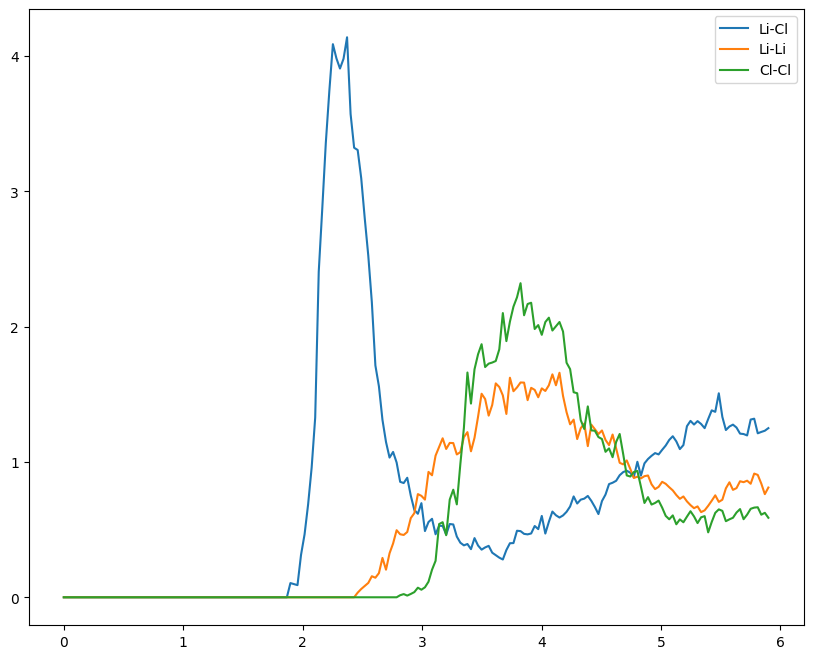

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def get_atom_positions(file_path, nLi, nCl):
    Li, Cl = [], []
    with open(file_path, 'r') as file:
        for line in file:
            if 'Li' in line:
                Li.append([float(line.split()[2]), float(line.split()[3]), float(line.split()[4])])
            if 'Cl' in line:
                Cl.append([float(line.split()[2]), float(line.split()[3]), float(line.split()[4])])
    return np.array(Li).reshape(-1, nLi, 3), np.array(Cl).reshape(-1, nCl, 3)

def get_gr(x, y, L): 
    batchsize, n, dim = x.shape[0], x.shape[1], x.shape[2]
    
    i,j = np.triu_indices(n, k=1)
    rij = (np.reshape(x, (-1, n, 1, dim)) - np.reshape(y, (-1, 1, n, dim)))[:,i,j]
    rij = rij - L*np.rint(rij/L)
    dist = np.linalg.norm(rij, axis=-1) # (batchsize, n*(n-1)/2)
   
    hist, bin_edges = np.histogram(dist.reshape(-1,), range=[0, L/2], bins=200)
    dr = bin_edges[1] - bin_edges[0]
    hist = hist*2/(n * batchsize)

    rmesh = np.arange(hist.shape[0])*dr
    
    h_id = 4/3*np.pi*n/(L**3)* ((rmesh+dr)**3 - rmesh**3 )
    return rmesh, hist/h_id

L = 11.858
nLi, nCl = 32, 32
Li, Cl = get_atom_positions('./LiCl_DP_Tutorial_Example/chapter2/abacus_md/OUT.ABACUS/MD_dump', nLi, nCl)

atom_pairs = {'Li-Cl': (Li, Cl),'Li-Li': (Li, Li),'Cl-Cl': (Cl, Cl)}

plt.figure(figsize=(10, 8))

for label, (x, y) in atom_pairs.items():
    rmesh, gr = get_gr(x, y, L)
    plt.plot(rmesh, gr, label=label)
    np.savetxt(f'./LiCl_DP_Tutorial_Example/chapter2/abacus_md/OUT.ABACUS/gr_{label}', np.column_stack((rmesh, gr)))
    
plt.legend()
plt.savefig('./LiCl_DP_Tutorial_Example/chapter2/abacus_md/abacus_md_rdf.png', dpi=300)
plt.show()

从 ABACUS MD计算的 RDF 如图。我们可以观察 ABACUS 和 LAMMPS MD 获得的 900K 下的 LiCl 熔体的 RDF 是否存在差异。注意，由于模拟体系较小和模拟时间较短，ABACUS MD 计算的 RDF 曲线并不光滑，更大的模拟体系或者更长的模拟时间将有助于改善这一情况。

**在这个练习中，我们学习了如何为 LiCl 熔体编写 ABACUS MD 计算输入文件，执行计算，和 MD 轨迹处理。**

## 章节 3：DeePMD-kit 深度势能 (DP) 模型训练

对于 LiCl 熔体，我们可以使用 DeePMD-kit 软件包，为其训练一个深度势能模型。DeePMD-kit 是一个基于深度学习的分子动力学模拟工具，可以根据第一性原理数据训练高精度的 DP 模型。在这个示例中，我们可以利用 ABACUS 第一性原理数据和 DeePMD-kit 训练一个 LiCl 熔体的 深度势能 (DP) 模型。

DeePMD-kit 的详细原理是：通过建立深度学习模型来学习高成本第一性原理计算获得的数据，得到的深度势能模型，并将该模型应用于后续的分子动力学模型中，用于控制分子间势，这即是「深度势能分子动力学」名称的由来。

DeePMD-kit 深度势能分子动力学方法大大节省了量子分子动力学所需的计算成本，将分子动力学模拟的规模从以往的几千原子提升至上亿原子的级别，同时也保留了显著优于经典分子动力学的模拟精度。相关成果曾获2020年度⾼性能计算领域最⾼奖 ACM 戈登贝尔奖。

### 本章节目标

学习完本课程后，你将能够：

- 掌握 DeePMD-kit 输入文件编写
- 能够进行数据准备、训练/冻结/压缩/测试和分子动力学任务



### 下载教程资源

在本章节中，我们以 LiCl 熔体分子为例,训练深度势能模型。我们已经在 *./LiCl_DP_Tutorial_Example/chapter3* 中准备了需要的文件。

In [ ]:
! if ! [ -e LiCl_DP_Tutorial_Example]; then wget https://bohrium-example.oss-cn-zhangjiakou.aliyuncs.com/notebook/LiCl_DP_Tutorial/LiCl_DP_Tutorial_Example.zip && unzip LiCl_DP_Tutorial_Example.zip; fi;

在 *./LiCl_DP_Tutorial_Example/chapter3* 文件夹下有 00.data，01.train 和 02.lmp 共 3 个子文件夹。

- *00.data* 文件夹用于存放训练和测试数据，
- *01.train* 包含使用 DeePMD-kit 训练模型的示例脚本，
- *02.lmp* 包含用于分子动力学模拟的 LAMMPS 示例脚本。

本教程采用 DeePMD-kit(2.2.1)程序完成。


### 3.1 准备训练数据

在 2.3 中已经执行了ABACUS MD 计算。你可以使用如下 Python 脚本，其中调用 [dpdata](https://github.com/deepmodeling/dpdata) 的工具，将 ABACUS MD 生成的数据（数据格式abacus/md）转换为 DeePMD-kit 训练所需的数据格式（NumPy数组）。

In [26]:
import dpdata 
import numpy as np

# 加载 abacus/md 格式数据
data = dpdata.LabeledSystem('./LiCl_DP_Tutorial_Example/chapter2/abacus_md', fmt = 'abacus/md')        

# 随机选择100个索引，用于生成验证集;其他的索引，用于生成测试集
index_validation = np.random.choice(len(data),size=100,replace=False)    
index_training = list(set(range(len(data)))-set(index_validation)) 

# 创建子数据集：训练集,测试集      
data_training = data.sub_system(index_training)                          
data_validation = data.sub_system(index_validation)

# 导出训练集,测试集（deepmd/npy格式）                     
data_training.to_deepmd_npy('./LiCl_DP_Tutorial_Example/chapter3/00.data/training_data')                                                       
data_validation.to_deepmd_npy('./LiCl_DP_Tutorial_Example/chapter3/00.data/validation_data')                         

print('# 数据包含 %d frames' % len(data))     
print('# 训练数据包含 %d frames' % len(data_training)) 
print('# 验证数据包含 %d frames' % len(data_validation))

# 数据包含 501 frames
# 训练数据包含 401 frames
# 验证数据包含 100 frames


我们可以看到 *abacus_md* 文件包含 501 帧数据。 我们随机选取 100 帧作为验证数据，其余的401帧作为训练数据。在开始训练之前，我们可以先检查 *training_data* 或 *validation_data* 文件夹。

In [ ]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/00.data/ && ls training_data

这些文件的作用如下：

1. `set.000`：是一个目录，包含压缩格式的数据（NumPy压缩数组）。所有训练数据应首先转换为此格式，然后在 DeePMD-kit 中使用。该数据格式在 DeePMD-kit 手册中有详细解释，可以在 [DeePMD-kit Data Introduction](https://github.com/deepmodeling/deepmd-kit/blob/edb4e6951f3300b8669e73fb34832f90c02c25f3/doc/data/index.md) 中找到。
2. `type.raw`：是一个文件，包含原子的类型（以整数表示）。
3. `type_map.raw`：是一个文件，包含原子的类型名称。

让我们来看一下这些文件：

In [27]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/00.data/ && cat training_data/type.raw 

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


这告诉我们这个例子中有 108 个原子，其中 54 个原子由类型"0"表示，54 个原子由类型"1"表示。有时需要将整数类型映射到原子名称。映射可以通过文件`type_map.raw`给出。

由于系统中的所有帧都具有相同的原子类型和原子序号，因此我们只需为整个系统指定一次类型信息。

In [28]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/00.data/ && cat training_data/type_map.raw

Li
Cl


其中原子 Li 被赋予类型 0，原子 Cl 被赋予类型 1。

### 3.2 准备输入脚本

训练数据准备完成后，接下来就可以进行训练。让我们进入训练目录看一下运行所需的脚本：

In [29]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/01.train/ && cat input.json

{
    "_comment": " model parameters",
    "model": {
	"type_map":	["Li", "Cl"],
	"descriptor" :{
	    "type":		"se_e2_a",
	    "sel":		[128, 128],
	    "rcut_smth":	0.50,
	    "rcut":		7.00,
	    "neuron":		[20, 40, 80],
	    "resnet_dt":	false,
	    "axis_neuron":	4,
	    "seed":		1,
	    "_comment":		" that's all"
	},
	"fitting_net" : {
	    "neuron":		[200, 200, 200],
	    "resnet_dt":	true,
	    "seed":		1,
	    "_comment":		" that's all"
	},
	"_comment":	" that's all"
    },

    "learning_rate" :{
	"type":		"exp",
	"decay_steps":	5000,
	"start_lr":	0.001,	
	"stop_lr":	3.51e-8,
	"_comment":	"that's all"
    },

    "loss" :{
	"type":		"ener",
	"start_pref_e":	0.02,
	"limit_pref_e":	1,
	"start_pref_f":	1000,
	"limit_pref_f":	1,
	"start_pref_v":	0,
	"limit_pref_v":	0,
	"_comment":	" that's all"
    },

    "training" : {
	"training_data": {
	    "systems":     ["../00.data/training_data"],
	    "batch_size":  "auto",
	    "_comment":	   "that's all"
	},
	"validation_data":{
	    "s


input.json 包含了 DP 模型训练过程中所需的各种参数，定义和控制训练任务。这些参数在 DeePMD-kit 手册中有详细的解释，所以这里只做简单介绍。

在 model 模块, 指定嵌入和拟合网络的参数。
```
    "model":{
    "type_map":    ["Li", "Cl"],                         # 元素名称
    "descriptor":{
        "type":            "se_e2_a",                    # 描述符类型
        "rcut":            7.00,                         # 截止半径
        "rcut_smth":       0.50,                         # 光滑截止半径
        "sel":             [128, 128],                   # 原子的选定邻居数
        "neuron":          [20, 40, 80],                 # 嵌入网络尺寸
        "resnet_dt":       false,
        "axis_neuron":     12,                           # 嵌入子网络横向尺寸
        "seed":            1,
        "_comment":        "that's all"
    },
    "fitting_net":{
        "neuron":          [200, 200, 200],              # 拟合网络尺寸
        "resnet_dt":       true,
        "seed":            1,
        "_comment":        "that's all"
    },
    "_comment":    "that's all"'
},
```
描述符 `se_e2_a` 用于 DP 模型的训练。将嵌入和拟合神经网络的大小分别设置为 [20, 40, 80] 和 [200, 200, 200]。 $\tilde{\mathcal{R}}^{i}$里的成分会从 0.5 到 7 Å 平滑地趋于 0。

下面的参数指定学习效率和损失函数：
```
    "learning_rate" :{
        "type":                "exp",
        "decay_steps":         5000,                      # 学习率下降间隔
        "start_lr":            0.001,                     # 起始学习率   
        "stop_lr":             3.51e-8,                   # 结束学习率 
        "_comment":            "that's all"
    },
    "loss" :{
        "type":                "ener",
        "start_pref_e":        0.02,                      # 能量起始权重
        "limit_pref_e":        1,                         # 能量最终权重
        "start_pref_f":        1000,                      # 力起始权重
        "limit_pref_f":        1,                         # 力最终权重
        "start_pref_v":        0,                         # 维里
        "limit_pref_v":        0,
        "_comment":            "that's all"
    },
```

在损失函数中，${pref\_e}$ 从 0.02 逐渐增加到 1 ${eV}^{-2}$，而 ${pref\_f}$ 从 1000 逐渐减小到 1 ${Å}^2 {eV}^{-2}$，这意味着力项在开始时占主导地位，而能量项和维里项在结束时变得重要。这种策略非常有效，并且减少了总训练时间。${pref\_v}$ 设为 0 ${eV}^{-2}$，这表明训练过程中不包含任何维里数据。将起始学习率、停止学习率和衰减步长分别设置为 0.001，3.51e-8，和 5000。模型训练步数为 $10^6$。


训练参数如下：
```
    "training" : {
        "training_data": {
            "systems":            ["../00.data/training_data"],         # 训练数据路径
            "batch_size":         "auto",                               # 自动确定，natoms*batch_size≥32
            "_comment":           "that's all"
        },
        "validation_data":{
            "systems":            ["../00.data/validation_data/"],
            "batch_size":         "auto",				
            "numb_btch":          1,                                    # 测试帧数
            "_comment":           "that's all"
        },
        "numb_steps":             400000,                               # 训练步数
        "seed":                   10,
        "disp_file":              "lcurve.out",                         # 写入学习曲线到文件
        "disp_freq":              1000,                                 # 写入学习曲线的频率
        "save_freq":              10000,                                # 保存模型相关文件频率
    },
```


### 3.3 模型训练

准备好训练脚本后，我们可以用 DeePMD-kit 开始训练，只需运行:

In [ ]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/01.train/ && dp train input.json


在 train.log 可以看到数据系统的信息
```
DEEPMD INFO      ----------------------------------------------------------------------------------------------------
DEEPMD INFO      ---Summary of DataSystem: training     -------------------------------------------------------------
DEEPMD INFO      found 1 system(s):
DEEPMD INFO                              system        natoms        bch_sz        n_bch          prob        pbc
DEEPMD INFO           ../00.data/training_data/            64             1          401         1.000          T
DEEPMD INFO      -----------------------------------------------------------------------------------------------------
DEEPMD INFO      ---Summary of DataSystem: validation   --------------------------------------------------------------
DEEPMD INFO      found 1 system(s):
DEEPMD INFO                               system       natoms        bch_sz        n_bch          prob        pbc
DEEPMD INFO          ../00.data/validation_data/           64             1          100         1.000          T
```


以及本次训练的开始和最终学习率
```
DEEPMD INFO      start training at lr 1.00e-03 (== 1.00e-03), decay_step 5000, decay_rate 0.950006, final lr will be 3.51e-08
```


如果一切正常，将在屏幕上看到每 1000 步打印一次的信息，例如
```
DEEPMD INFO    batch    1000 training time 69.23 s, testing time 0.06 s
DEEPMD INFO    batch    2000 training time 68.00 s, testing time 0.06 s
DEEPMD INFO    batch    3000 training time 67.80 s, testing time 0.06 s
DEEPMD INFO    batch    4000 training time 69.92 s, testing time 0.07 s
DEEPMD INFO    batch    5000 training time 67.98 s, testing time 0.06 s
```
 在第 10000 步结束时，模型保存在 TensorFlow 的检查点文件 model.ckpt 中。 同时，训练和测试错误显示在文件 lcurve.out 中。


In [33]:
! cat ./LiCl_DP_Tutorial_Example/chapter3/01.train/lcurve.out

'''
#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      1.41e+01    1.27e+01      3.50e-01    3.35e-01      4.45e-01    4.02e-01    1.0e-03
...
 399000      1.57e-02    1.55e-02      8.17e-05    4.88e-04      1.53e-02    1.47e-02    4.0e-08
 400000      1.55e-02    1.54e-02      2.68e-04    4.64e-04      1.51e-02    1.47e-02    3.5e-08
'''


#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      1.41e+01    1.27e+01      3.50e-01    3.35e-01      4.45e-01    4.02e-01    1.0e-03
   1000      1.65e+00    1.71e+00      9.59e-02    9.78e-02      5.20e-02    5.40e-02    1.0e-03
   2000      1.21e+00    1.28e+00      4.74e-02    4.56e-02      3.83e-02    4.03e-02    1.0e-03
   3000      1.07e+00    1.14e+00      8.74e-02    8.89e-02      3.37e-02    3.60e-02    1.0e-03
   4000      9.39e-01    9.45e-01      4.93e-02    4.93e-02      2.96e-02    2.98e-02    1.0e-03
   5000      8.97e-01    1.10e+00      1.36e-02    1.41e-02      3.02e-02    3.72e-02    8.8e-04
   6000      8.47e-01    9.72e-01      2.08e-02    1.95e-02      2.85e-02    3.27e-02    8.8e-04
   7000      8.22e-01    9.02e-01      1.57e-02    1.51e-02      2.77e-02    3.04e-02    8.8e-04
   8000      7.61e-01    8.46e-01      1.46e-02    1.50e-02      2.56e-02    2.85e-02    8.8e-04
   9000      9.16e-01    8.04e

'\n#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr\n      0      1.41e+01    1.27e+01      3.50e-01    3.35e-01      4.45e-01    4.02e-01    1.0e-03\n...\n 399000      1.57e-02    1.55e-02      8.17e-05    4.88e-04      1.53e-02    1.47e-02    4.0e-08\n 400000      1.55e-02    1.54e-02      2.68e-04    4.64e-04      1.51e-02    1.47e-02    3.5e-08\n'

第 4、5 和 6、7 列分别介绍了能量和力的训练和测试误差。 经过 4000,00 步训练，能量测试误差小于 1 meV，力测试误差小于 20 meV/Å。可以通过简单的 Python 脚本对该文件进行可视化：


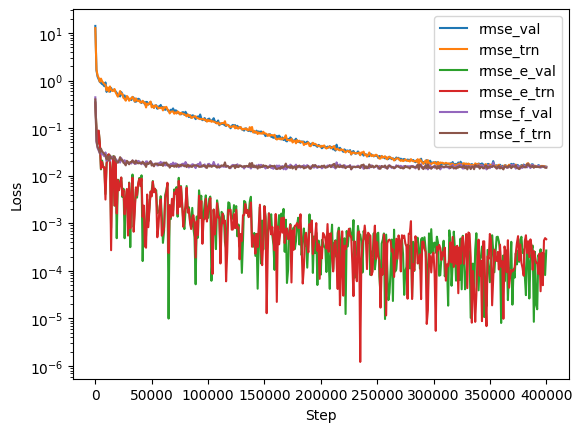

In [30]:
import numpy as np
import matplotlib.pyplot as plt

data = np.genfromtxt("./LiCl_DP_Tutorial_Example/chapter3/01.train/lcurve.out", names=True)
for name in data.dtype.names[1:-1]:
    plt.plot(data['step'], data[name], label=name)
plt.legend()
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()


当训练过程异常停止时，我们可以从提供的检查点重新开始训练，只需运行

In [ ]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/01.train/ && dp train --restart model.ckpt input.json

需要注意的是 *input.json* 需要和上一个保持一致。



### 3.4 冻结和压缩模型

在训练结束时，保存在 TensorFlow 的 checkpoint 文件中的模型参数通常需要冻结为一个以扩展名 .pb 结尾的模型文件。 只需执行：


In [ ]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/01.train/ && dp freeze -o licl.pb

它将在当前目录中输出一个名为 graph.pb 的模型文件。 压缩 DP 模型通常会将基于 DP 的计算速度提高一个数量级，并且消耗更少的内存。 licl.pb 可以通过以下方式压缩：


In [34]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/01.train/ && dp compress -i licl.pb -o licl-compress.pb

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2023-04-25 12:14:03.487429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/oneapi/tbb/2021.5.1/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.5.1//libfabric/lib:/opt/intel/oneapi/mpi/2021.5.1//lib/release:/opt/intel/oneapi/mpi/2021.5.1//lib:/opt/intel/oneapi/mkl/2022.0.2/lib/intel64:/opt/intel/oneapi/debugger/2021.5.0/gdb/intel64/lib:/opt/intel/oneapi/debugger/2021.5.0/libipt/intel64/lib:/opt/intel/oneapi/debugger/2021.5.0/dep/lib:/opt/intel/oneapi/compiler/2022.0.2/linux/lib:/opt/intel/

将输出一个名为 licl-compress.pb 的模型文件。



### 3.5 模型测试
我们可以通过运行如下命令检查训练模型的质量


In [35]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/01.train/ && dp test -m licl-compress.pb -s ../00.data/validation_data -n 100 -d results

Instructions for updating:
non-resource variables are not supported in the long term
/opt/deepmd-kit-2.2.1/lib/python3.10/importlib/__init__.py:169: UserWarning: The NumPy module was reloaded (imported a second time). This can in some cases result in small but subtle issues and is discouraged.
  _bootstrap._exec(spec, module)
2023-04-25 12:14:45.346138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/oneapi/tbb/2021.5.1/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.5.1//libfabric/lib:/opt/intel/oneapi/mpi/2021.5.1//lib/release:/opt/intel/oneapi/mpi/2021.5.1//lib:/opt/intel/oneapi/mkl/2022.0.2/lib/intel64:/opt/intel/oneapi/debugger/2021.5.0/gdb/intel64/lib:/opt/intel/oneapi/debugger/2021.5.0/libipt/intel64/lib:/opt/intel/oneapi/debugger/2021.5.0/dep/lib:/opt/intel/oneapi/compiler/2022.0.2/linux/lib:/opt/intel/

在屏幕上，可以看到验证数据的预测误差信息。

它将在当前目录中输出名为 results.e.out 和 results.f.out 的文件。类似地，可以通过简单的 Python 脚本对该文件进行可视化：


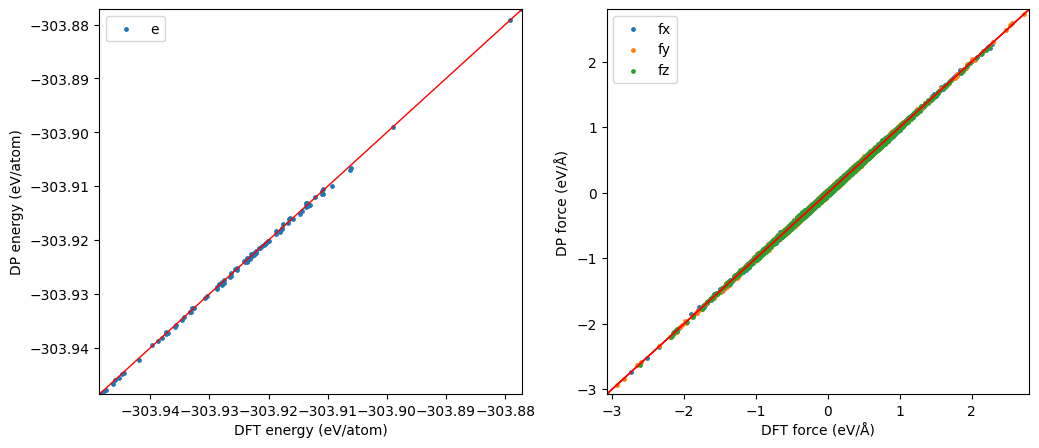

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 定义绘制散点图和对角线的函数
def plot(ax, data, key, xlabel, ylabel, min_val, max_val):
    data_key = f'data_{key}'
    pred_key = f'pred_{key}'
    ax.scatter(data[data_key], data[pred_key], label=key, s=6)
    ax.legend()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.plot([min_val, max_val], [min_val, max_val], 'r', lw=1)

# 读取数据，并对e数据进行原子化处理
natom = 64
data_e = np.genfromtxt("./LiCl_DP_Tutorial_Example/chapter3/01.train/results.e.out", names=["data_e", "pred_e"])
data_f = np.genfromtxt("./LiCl_DP_Tutorial_Example/chapter3/01.train/results.f.out", names=["data_fx", "data_fy", "data_fz", "pred_fx", "pred_fy", "pred_fz"])

for col in ['data_e', 'pred_e']:
    data_e[col] /= natom

# 计算e和f的最小值和最大值
data_e_stacked = np.column_stack((data_e['data_e'], data_e['pred_e']))
data_f_stacked = np.column_stack((data_f['data_fx'], data_f['data_fy'], data_f['data_fz'], data_f['pred_fx'], data_f['pred_fy'], data_f['pred_fz']))

min_val_e, max_val_e = np.min(data_e_stacked), np.max(data_e_stacked)
min_val_f, max_val_f = np.min(data_f_stacked), np.max(data_f_stacked)

# 绘制散点图并保存结果
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot(axs[0], data_e, 'e', 'DFT energy (eV/atom)', 'DP energy (eV/atom)', min_val_e, max_val_e)
for force_direction in ['fx', 'fy', 'fz']:
    plot(axs[1], data_f, force_direction, 'DFT force (eV/Å)', 'DP force (eV/Å)', min_val_f, max_val_f)
plt.show()

### 3.6 使用 LAMMPS 运行深度势能分子动力学


首先，我们将 *01.train* 目录中的 DP 模型复制到 *02.lmp* 目录

In [ ]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/02.lmp/ && cp ../01.train/licl-compress.pb ./

让我们查看一下 *02.lmp* 目录下的文件：

In [38]:
! cd ./LiCl_DP_Tutorial_Example/chapter3/02.lmp/ && ls

64_dpmd_rdf.png  licl.data  licl.in   log.lammps
ave_rdf.txt	 licl.dump  licl.rdf



其中 licl.data 给出了 LiCl 熔体 MD 模拟的初始配置，文件 licl.in 是 lammps 输入脚本。 可以检查 licl.in 并发现它是一个用于 MD 模拟的相当标准的 LAMMPS 输入文件，与章节 1 中的 licl.in 文件相比，在原子类型和势函数参数设置上略有不同：

```
atom_style  atomic
```
和

```
pair_style  licl-compress.pb
pair_coeff  * *
```

其中调用 pair style deepmd 并提供模型文件 licl-compress.pb，这意味着原子间相互作用将由名为 licl-compress.pb 的 DP 模型计算。可以以标准方式执行：


In [ ]:
# ###### Time Warning: 19 minutes 16 seconds #####################
! cd ./LiCl_DP_Tutorial_Example/chapter3/02.lmp/ && lmp -i licl.in

稍等片刻，MD 模拟结束，生成 log.lammps 和 licl.dump 文件。 它们分别存储热力学信息和分子的轨迹，我们可以使用 chapter1 中提供的 Python 脚本计算 RDF。

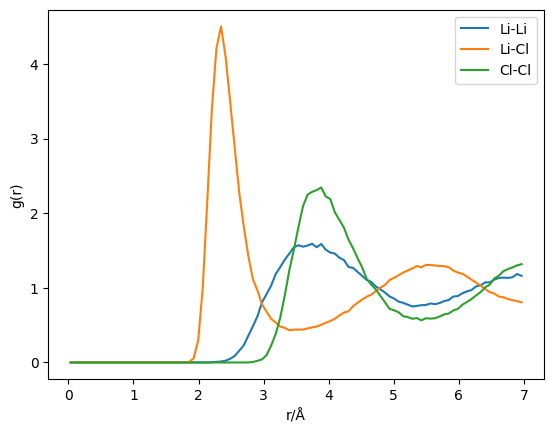

In [39]:
import numpy as np
import matplotlib.pyplot as plt

nbins = 100 # define the number of bins in the RDF

with open("./LiCl_DP_Tutorial_Example/chapter3/02.lmp/licl.rdf", "r") as f: # read the licl.rdf file
    lines = f.readlines()
    lines = lines[3:]

    data = np.zeros((nbins, 7))  
    count = 0  

    for line in lines:  
        nums = line.split()      
        if len(nums) == 8:  
            for i in range(1, 8):  
                data[int(nums[0])-1, i-1] += float(nums[i])  # accumulatie data for each bin  
        if len(nums) == 2:  
            count += 1         # count the number of accumulations for each bin
       
ave_rdf = data / count  # calculate the averaged RDF data
np.savetxt('ave_rdf.txt', ave_rdf)

labels = ['Li-Li', 'Li-Cl', 'Cl-Cl']
for i, label in zip(range(1, 7, 2), labels):
    plt.plot(ave_rdf[:, 0], ave_rdf[:, i], label=label)
plt.xlabel('r/Å')
plt.ylabel('g(r)')
plt.legend()
plt.savefig('./LiCl_DP_Tutorial_Example/chapter3/02.lmp/64_dpmd_rdf.png', dpi=300)
plt.show()

让我们来对比一下由经典分子动力学、量子分子动力学、深度势能分子动力学计算得到的 rdf 曲线：

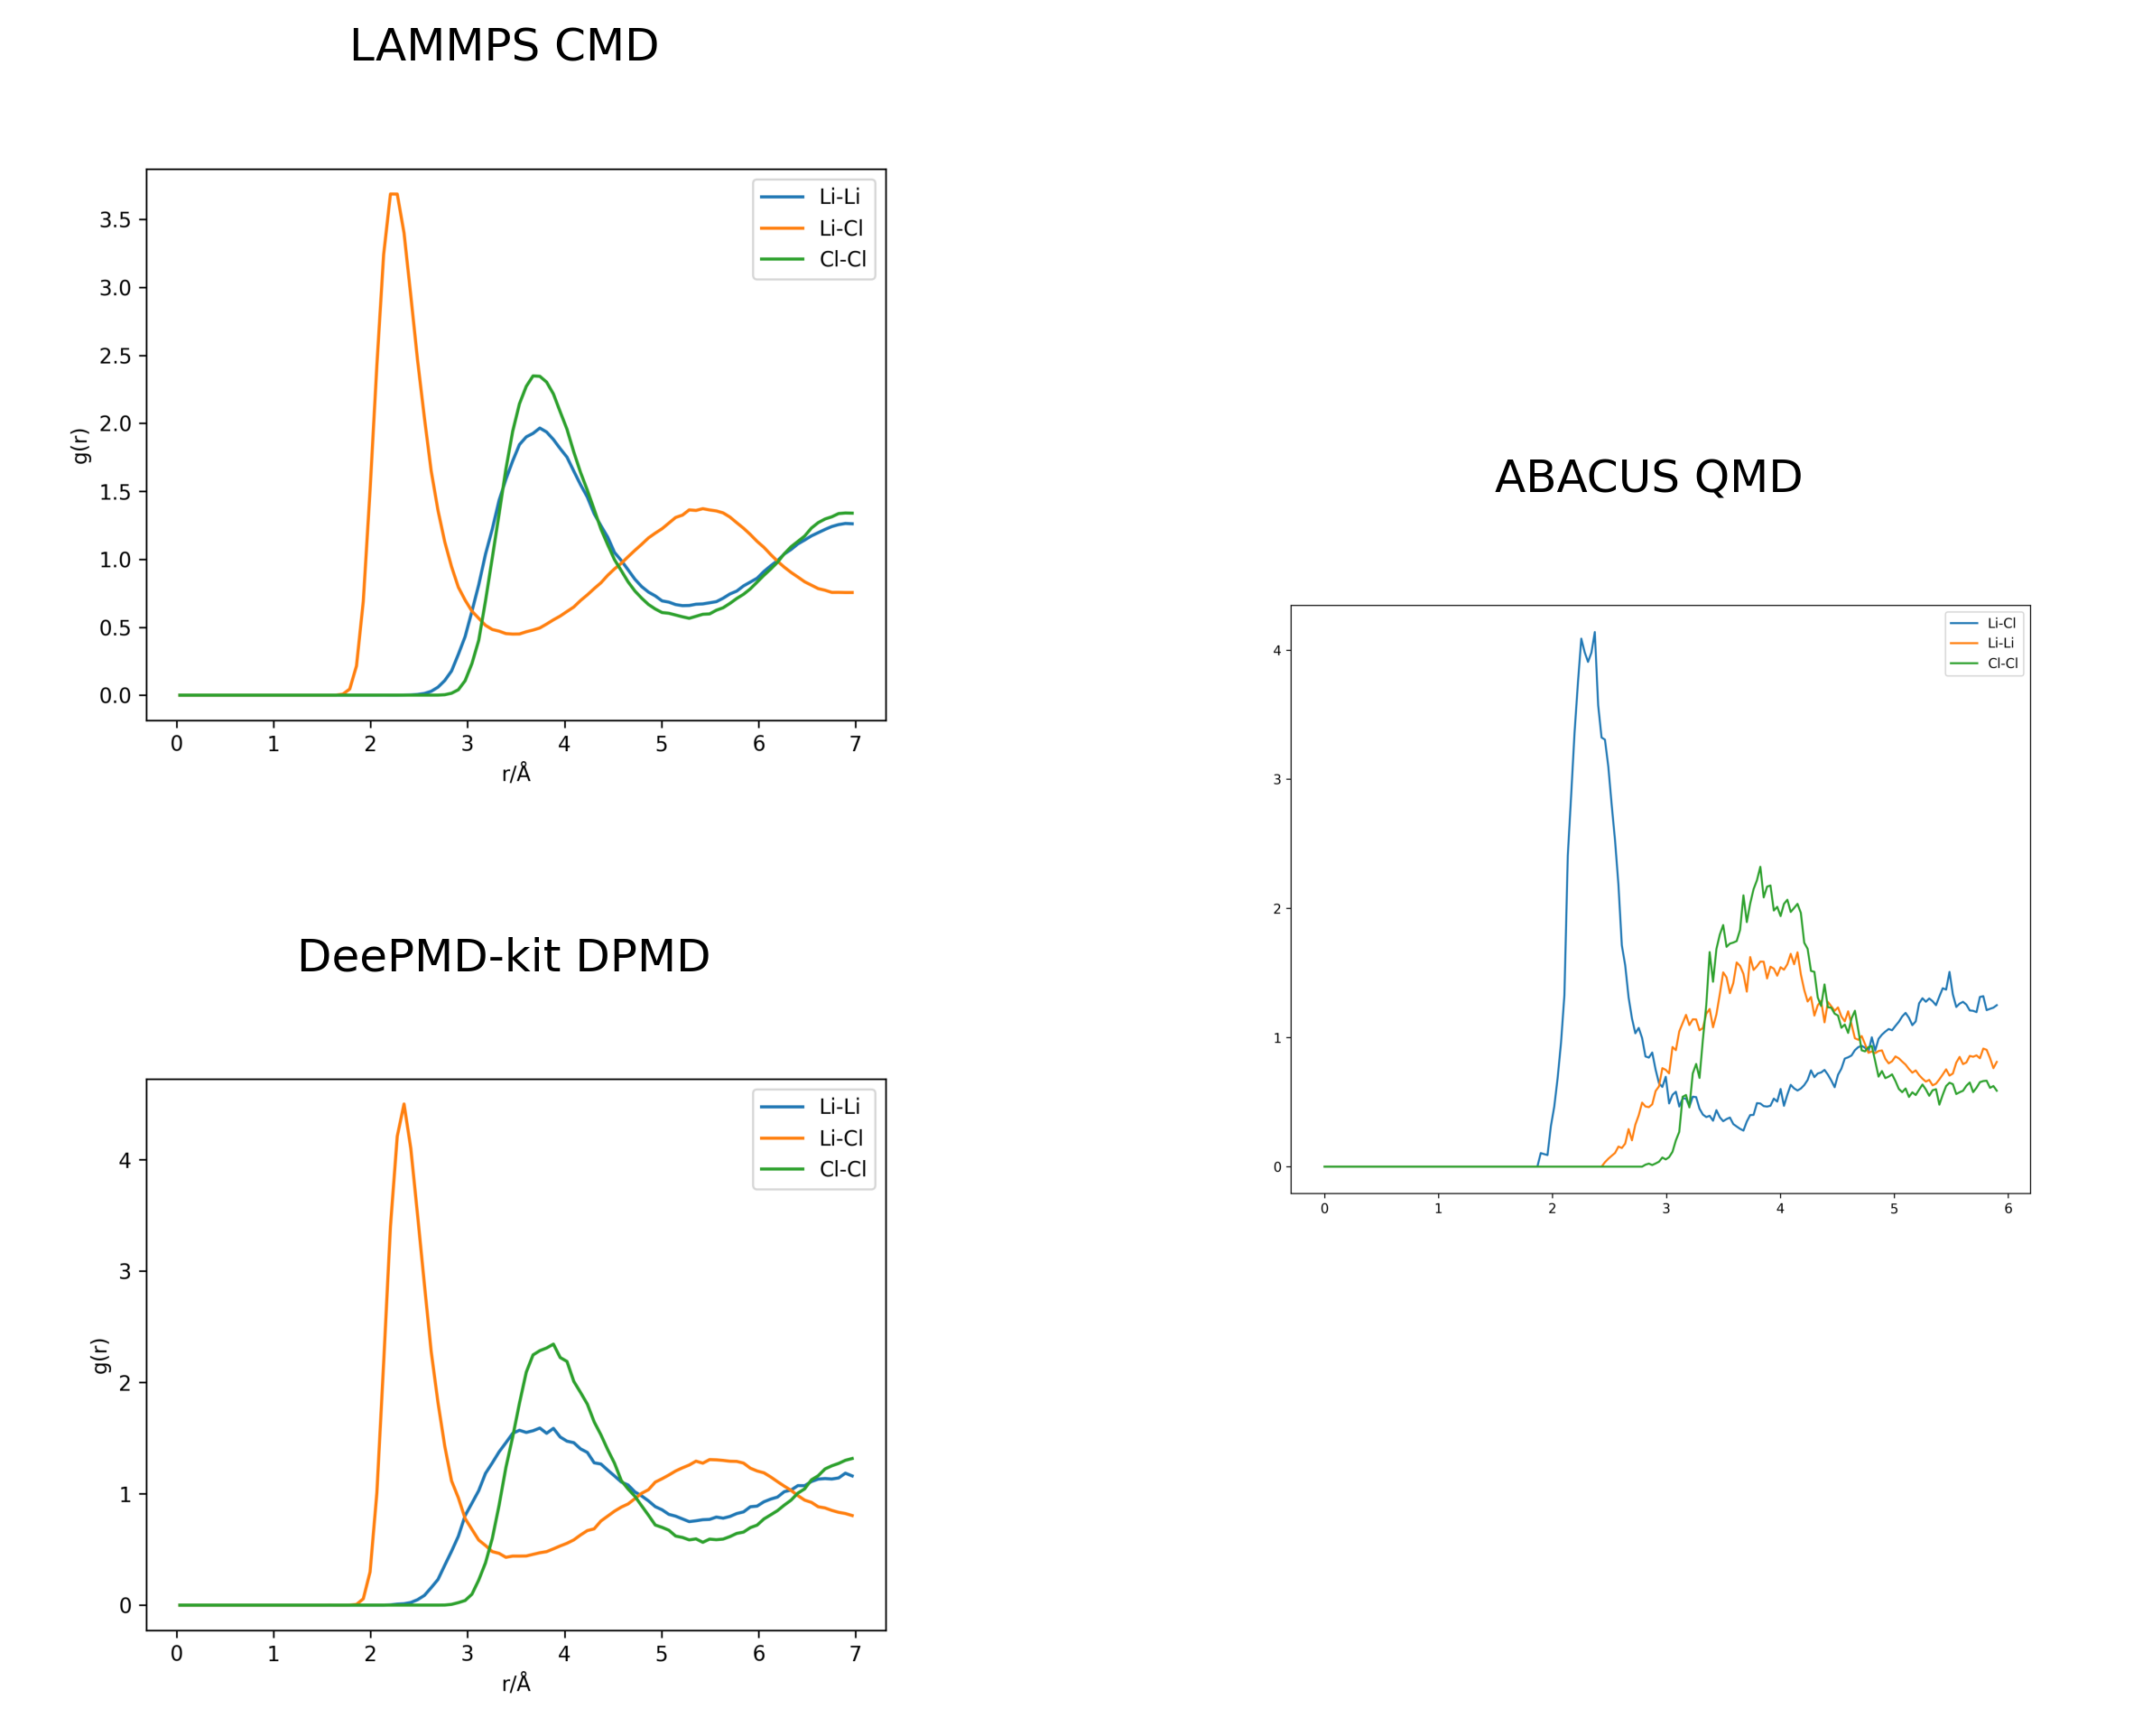

In [40]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 读取图片
cmd_rdf = mpimg.imread('./LiCl_DP_Tutorial_Example/chapter1/rdf.png')
qmd_rdf = mpimg.imread('./LiCl_DP_Tutorial_Example/chapter2/abacus_md/abacus_md_rdf.png')
dpmd_rdf = mpimg.imread('./LiCl_DP_Tutorial_Example/chapter3/02.lmp/64_dpmd_rdf.png')

# 设置画布大小
fig, axd = plt.subplot_mosaic([['upleft', 'right'],
                               ['lowleft', 'right']], figsize=(10,8), dpi=300)

# 添加子图1
axd['upleft'].set_title('LAMMPS CMD')
axd['upleft'].imshow(cmd_rdf)
axd['upleft'].axis('off')

# 添加子图2
axd['right'].set_title('ABACUS QMD')
axd['right'].imshow(qmd_rdf)
axd['right'].axis('off')

# 添加子图3
axd['lowleft'].set_title('DeePMD-kit DPMD')
axd['lowleft'].imshow(dpmd_rdf)
axd['lowleft'].axis('off')

# 显示图片
plt.show()

可以发现，相对于 LAMMPS 经典分子动力学计算得到的结果，由 DeePMD-kit 深度势能分子动力学计算得到的结果更接近 ABACUS 量子分子动力学得到的结果，具有更高的准确度。

而在模拟步数为量子分子动力学的 1000000/500 = 200 倍的情况下，时间仅为 19 mins / 9 h 30 mins = 0.03。在保证较高精度的前提下，大大降低了计算成本。



接下来，我们将使用 DP-GEN 工作流进一步优化我们的深度势能分子动力学模拟。在更大空间和时间尺度上研究 LiCl 熔体的结构、动力学和热力学性质。

<a href="https://bohrium.dp.tech/notebook/879b6a3a9d394448913ca1ce7de257ec" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>